# TCC ML Amazônia - Anexo A

## Google Colab Notebook: Construção do Data-Set utilizando o projeto RAISG e o Google Earth Engine

Author: Leonardo Grupioni

  Positive class  → áreas de garimpo ilegal (RAISG 2022/23)
  
  Negative class  → áreas naturais protegidas SEM garimpo (RAISG 2024)

Objetivo: gerar patches Sentinel‑2 (RGB + NIR) de 256×256 px, separados em pastas 'dataset/pos/' e 'dataset/neg/', prontos para treinar redes neurais convolucionais em Python.

### Informações extraidos do projeto RAISG com regiões de áreas protegidas naturais e áreas de mineração ilegal:

• RAISG shapefile   → `Garimpo_2022.zip`  

• Áreas protegidas  → `ProtectedAreas_AMZ.zip`


In [ ]:
# 0 - Preparar e montar o Google Drive

from google.colab import drive
DRIVE_MOUNT = True
if DRIVE_MOUNT:
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/TCC_ML_Amazonia'
else:
    BASE_DIR = '/content/TCC_ML_Amazonia'

import os, pathlib
INPUT_DIR_GAR = f"{BASE_DIR}/input/Garimpo_2022"
INPUT_DIR_ANP = f"{BASE_DIR}/input/Anps2024"
RAW_DIR       = f"{BASE_DIR}/gee_patches_raw"
OUT_DIR       = f"{BASE_DIR}/dataset"
for p in [RAW_DIR, f"{OUT_DIR}/pos", f"{OUT_DIR}/neg"]:
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)
print('📂  BASE_DIR  :', BASE_DIR)
print('📂  RAW_DIR   :', RAW_DIR)
print('📂  OUT_DIR   :', OUT_DIR)


Mounted at /content/drive
📂  BASE_DIR  : /content/drive/MyDrive/TCC_ML_Amazonia
📂  RAW_DIR   : /content/drive/MyDrive/TCC_ML_Amazonia/gee_patches_raw
📂  OUT_DIR   : /content/drive/MyDrive/TCC_ML_Amazonia/dataset


In [ ]:
# 1 – Instalar e importar bibliotecas

!pip -q install geopandas geemap earthengine-api rasterio pillow tqdm pandas==2.2.2 matplotlib seaborn --upgrade

import ee, geemap, geopandas as gpd, json, random, math, glob, numpy as np
import pandas as pd, matplotlib.pyplot as plt, matplotlib.patches as mpatches
import rasterio
from rasterio.enums import Resampling
from PIL import Image
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.8 MB/s eta 0:00:00


In [ ]:
# 2 - Autenticar e inicializar o Google Earth Engine (projeto tonal-history-438001-v5)

ee.Authenticate()
ee.Initialize(project='tonal-history-438001-v5')
print('Earth Engine inicializado!')

Earth Engine inicializado!


In [ ]:
# TUNE – CONFIGURAÇÃO PRINCIPAL

PATCH_PX       = 256      # pixels por lado
SCALE          = 10       # metros/pixel (Sentinel‑2 B4/B3/B2/B8)
RADIUS_M       = PATCH_PX//2 * SCALE   # 1 280 m
SAMPLES_PER_CLS= 2500     # total desejado p/ cada classe
BATCH_SIZE     = 500      # feições enviadas por lote (não passar de 5 000)
YEAR_START, YEAR_END = '2023-01-01', '2023-12-31'

In [ ]:
# 3 – Ler shapefiles locais e transformar em GeoDataFrame

def read_shp(folder, name):
    shp_path = glob.glob(f"{folder}/{name}.shp")[0]
    return gpd.read_file(shp_path)

gdf_gar   = read_shp(INPUT_DIR_GAR, 'MineriaIlegal_pol')
gdf_anp   = gpd.GeoDataFrame(pd.concat([
                read_shp(INPUT_DIR_ANP,'ANP_BosqueProtector'),
                read_shp(INPUT_DIR_ANP,'ANP_Departamental'),
                read_shp(INPUT_DIR_ANP,'ANP_Nacional'),
                read_shp(INPUT_DIR_ANP,'ANP_ReservaFlorestal')
            ], ignore_index=True))
print('🛈 Polígonos garimpo :', len(gdf_gar))
print('🛈 Polígonos ANP     :', len(gdf_anp))

🛈 Polígonos garimpo : 3816
🛈 Polígonos ANP     : 925


In [ ]:
# 4 – Criar compósito Sentinel‑2 SR (2023) com máscara de nuvem

s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate(YEAR_START, YEAR_END)
        .filter('CLOUDY_PIXEL_PERCENTAGE < 20'))

def mask_cloud(img):
    qa = img.select('QA60')
    mask = qa.bitwiseAnd(1<<10).eq(0).And( qa.bitwiseAnd(1<<11).eq(0))
    return img.updateMask(mask).divide(10000)

s2_comp = s2.map(mask_cloud).median().select(['B4','B3','B2','B8'])
print('Compósito Sentinel‑2 2023 pronto')

Compósito Sentinel‑2 2023 pronto


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
# 5 – Funções auxiliares

def to_ee_geom(py_geom):
    """GeoPandas geometry em ee.Geometry buffered & squared"""
    g = ee.Geometry(py_geom.__geo_interface__)
    return g.buffer(RADIUS_M).bounds()

def export_patch(geom, label, idx):
    desc = f"{label}_{idx:06d}"
    ee.batch.Export.image.toDrive(
        image      = s2_comp.clip(geom),
        description= desc,
        folder     = os.path.basename(RAW_DIR),
        fileNamePrefix = desc,
        region     = geom,
        scale      = SCALE,
        maxPixels  = 1e13,
        fileFormat = 'GeoTIFF').start()

In [ ]:
 # 6 – Tasks no google earth engine

 def run_class(gdf, label):
    gdf = gdf.sample(min(SAMPLES_PER_CLS, len(gdf)), random_state=1)
    total = len(gdf)
    batches = math.ceil(total / BATCH_SIZE)
    idx = 0
    for b in range(batches):
        sub = gdf.iloc[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        for _, row in sub.iterrows():
            export_patch(to_ee_geom(row.geometry), label, idx)
            idx += 1
        print(f'  Lote {b+1}/{batches} da classe {label.upper()} enviado.')

run_class(gdf_gar, 'pos')
run_class(gdf_anp, 'neg')
print('\nAbra https://code.earthengine.google.com/ → aba *Tasks* → marque “RUN ALL”.')


  Lote 1/5 da classe POS enviado.
  Lote 2/5 da classe POS enviado.
  Lote 3/5 da classe POS enviado.
  Lote 4/5 da classe POS enviado.
  Lote 5/5 da classe POS enviado.
  Lote 1/2 da classe NEG enviado.


EEException: Too many tasks already in the queue (3000, limit 3000).

In [ ]:
# 7 – Converter GeoTIFF em PNG (executado depois que todos os .tif foram exportados para o RAW_DIR)

import glob, numpy as np, rasterio, os
from rasterio.enums import Resampling
from PIL import Image
from pathlib import Path

PATCH_PX = 256

def tif2png(tif_path, out_dir):
    with rasterio.open(tif_path) as src:
        img = src.read([1,2,3], out_shape=(3, PATCH_PX, PATCH_PX),
                       resampling=Resampling.bilinear)
        img = np.transpose(img, (1, 2, 0))
        img = ((img - img.min()) /
               (img.max() - img.min() + 1e-6) * 255).astype(np.uint8)
        Image.fromarray(img).save(
            f"{out_dir}/{Path(tif_path).stem}.png")

RAW_DIR = '/content/drive/MyDrive/TCC_ML_Amazonia/gee_patches_raw'
OUT_DIR = '/content/drive/MyDrive/TCC_ML_Amazonia/dataset'

files = glob.glob(f"{RAW_DIR}/*.tif")
print(f"➡️  Convertendo {len(files)} GeoTIFFs… (pode levar alguns minutos)")

for tif in files:
    sub = 'pos' if Path(tif).stem.startswith('pos') else 'neg'
    tif2png(tif, f"{OUT_DIR}/{sub}")

print('✅ PNGs prontos em', OUT_DIR)

➡️  Convertendo 1153 GeoTIFFs… (pode levar alguns minutos)


<ipython-input-11-944731c0bf60>:16: RuntimeWarning: invalid value encountered in cast
  (img.max() - img.min() + 1e-6) * 255).astype(np.uint8)


✅ PNGs prontos em /content/drive/MyDrive/TCC_ML_Amazonia/dataset


# Visualização do DataSet


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Positivos: 786  |  Negativos: 367


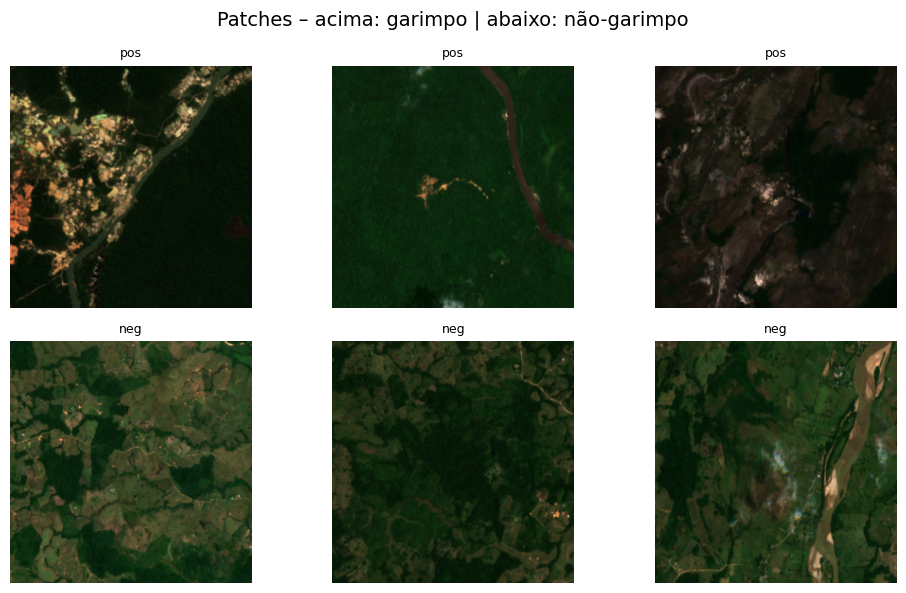

In [ ]:
# Visualizar 3 amostras positivas e 3 negativas
import os, glob, random
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive

# 1) Monta o Google Drive
drive.mount('/content/drive')

# 2) Pasta-raiz onde ficam pos/ e neg/
BASE_DIR = '/content/drive/MyDrive/TCC_ML_Amazonia/dataset'
POS_DIR  = os.path.join(BASE_DIR, 'pos')
NEG_DIR  = os.path.join(BASE_DIR, 'neg')

# 3) Extensões de imagem aceitas
EXTENSIONS = ('*.png', '*.jpg', '*.jpeg')

def collect(folder):
    files = []
    for ext in EXTENSIONS:
        files.extend(glob.glob(os.path.join(folder, '**', ext), recursive=True))
    return files

pos_imgs = collect(POS_DIR)
neg_imgs = collect(NEG_DIR)
print(f'Positivos: {len(pos_imgs)}  |  Negativos: {len(neg_imgs)}')

def sample(img_list, n=3):
    n = min(n, len(img_list))
    return random.sample(img_list, n) if n else []

pos_sample = sample(pos_imgs, 3)
neg_sample = sample(neg_imgs, 3)

if len(pos_sample) < 3 or len(neg_sample) < 3:
    raise ValueError('Menos de 3 imagens em alguma classe. Verifique os caminhos.')

# 4) Exibir grade 2 × 3
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Patches – acima: garimpo | abaixo: não-garimpo', fontsize=14)

for ax, img_path in zip(axes[0], pos_sample):
    ax.imshow(Image.open(img_path))
    ax.set_title('pos', fontsize=9)
    ax.axis('off')

fig.suptitle('Patches – acima: garimpo | abaixo: não-garimpo', fontsize=14)

for ax, img_path in zip(axes[1], neg_sample):
    ax.imshow(Image.open(img_path))
    ax.set_title('neg', fontsize=9)
    ax.axis('off')

plt.tight_layout()
